In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings("ignore")

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite", echo=False)

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)


In [7]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first().date
most_recent_date

'2017-08-23'

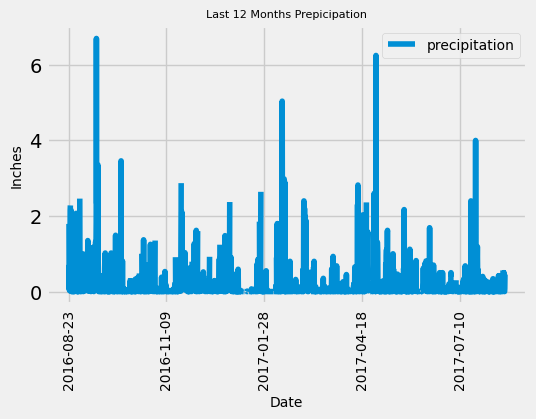

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year_ago =dt.datetime.strptime(most_recent_date, '%Y-%m-%d') - dt.timedelta(days=365)
one_year_ago.date()

# Perform a query to retrieve the data and precipitation scores
last_year_precipitation = session.query(Measurement.date, Measurement.prcp).\
filter(Measurement.date >= one_year_ago.date()).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
last_year_prcp_df = pd.DataFrame(last_year_precipitation, columns=['date', 'precipitation'])
last_year_prcp_df.set_index('date', inplace=True)

# Sort the dataframe by date
last_year_prcp_df = last_year_prcp_df.sort_values(by=['date'])

# Use Pandas Plotting with Matplotlib to plot the data

last_year_prcp_df.plot(y='precipitation', use_index=True)
plt.title('Last 12 Months Prepicipation', fontsize=8)
plt.xlabel('Date', fontsize= 10)
plt.ylabel('Inches', fontsize=10)
plt.xticks(rotation=90, fontsize=10)
plt.legend(loc='best', fontsize=10, fancybox=True)

plt.subplots_adjust(left=0.2, bottom=0.3)



plt.savefig("12_Months_Prepicipation.png")
plt.show()

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
last_year_prcp_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number of stations in the dataset
station_num = session.query(func.count(Station.name)).all()
station_num

[(9,)]

In [14]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_count = session.query(Measurement.station, func.count(Measurement.id)).\
filter(Measurement.station == Station.station).\
group_by(Measurement.station).\
order_by(func.count(Measurement.id).desc()).all()
station_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

station_activity = [{"station_id": result[0], "station_count": result[1]} for result in station_count]
most_active = station_activity[0]['station_id']

sel = [func.min(Measurement.tobs).label("min_temp"), 
                  func.max(Measurement.tobs).label("max_temp"), 
                  func.round(func.avg(Measurement.tobs), 2).label("avg_temp")]

active_station_temp = session.query(*sel).\
    filter(Measurement.station == most_active).all()


active_station_temp


[(54.0, 85.0, 71.66)]

In [20]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station 

last_year_temp = session.query(Measurement.station,Station.name, Measurement.date, Measurement.tobs).\
filter(Measurement.date >= one_year_ago.date()).\
filter(Measurement.station == Station.station).\
filter(Measurement.station == most_active).all()

# Save the query results as a Pandas DataFrame. (Setting the column names)
last_year_temp_df = pd.DataFrame(last_year_temp, columns=["station_id","station_name","date","tobs"])

# Sort the dataframe by date
last_year_temp_df.sort_values(by=['date'], inplace=True)


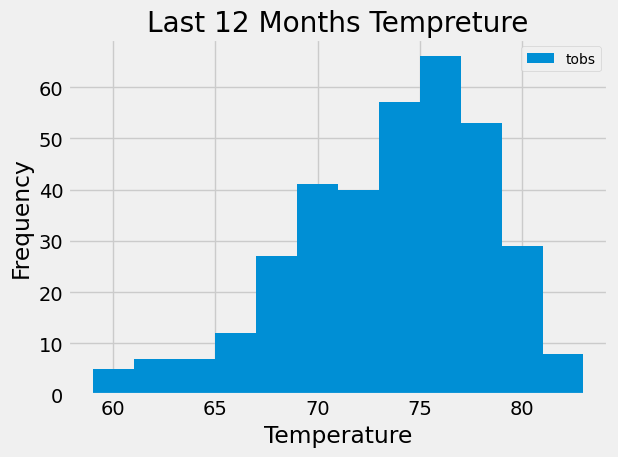

In [18]:
# plot the results as a histogram

last_year_temp_df.plot.hist(bins=12)
plt.title('Last 12 Months Tempreture')
plt.xlabel('Temperature')
plt.tight_layout()
plt.legend(loc='best', fontsize=10, fancybox=True)
plt.savefig("12_Months_tobs.png")
plt.show()

# Close Session

In [39]:
# Close Session
session.close()